# Keşifsel Veri Analizi

## Aykırı Değerler 

Bu ödevde ABD Eğitim Sistemi'ne ait verileri inceleyemeye devam edeceksiniz. Bu veri kümesinde eyalet bazında yıllık bir çok veri bulunmaktadır. Bu verilerin açıklamalarına yine Kaggle'dan ulaşabilirsiniz.

Öncelikle bir önceki derste uyguladağınız eksik değerleri tamamlama tekniklerinden en uygun olanını uygulayın. Aşağıdaki sorulara cevap verebilmeniz için eksik verilerin üstesinden gelmelisiniz.

### Q1
Toplam gelir verilerini içeren TOTAL_REVENUE ve toplam harcama verilerini içeren TOTAL_EXPENDITURE değişkenlerini inceleyin. Bu değişkenler aykırı değerler içeriyor mu?

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# custom font defs
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 22}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 16 }

df = pd.read_csv('states_all.csv')

In [206]:
# make a list of duplicates that have spaces in its state name
list_of_dups = []
for i in np.unique(df[['STATE']]):
    if (' ' in i) == True:
        list_of_dups.append(i)
#print(list_of_dups)

# concat the duplicated(with space char in state name) states to form a new data frame dd
dd = pd.DataFrame()
for i in list_of_dups:
    dd = pd.concat([dd,df.loc[df['STATE']== i]])


# replace spaces with '_' in STATE and PKEY columns
for state in list_of_dups:
    #print(i.replace(' ','_'))
    dd = dd.replace(state , state.replace(' ','_'))
    for year in np.unique(dd['YEAR']):
        pkey = str(year)+'_'+state
        dd = dd.replace(pkey , pkey.replace(' ','_'))
       

dd = dd.set_index('PRIMARY_KEY')
dd = dd.sort_index()

# make list of duplicate primary keys which contains spaces
list_of_dups_pkey = []
for i in np.unique(df[['PRIMARY_KEY']]):
    if (' ' in i) == True:
        list_of_dups_pkey.append(i)

# set index to the primary_key
dfp = df.set_index('PRIMARY_KEY')
for pkey in list_of_dups_pkey:
    dfp.drop(pkey, inplace = True)

# sort by primary key index
dfp=dfp.sort_index()

# make a list of drop list for dd dataframe which has null columns entirely
column_names = list(df.columns)
droplist=[]
# start from the ENROLL column
for i in column_names[3:]:
    #print(i,dd[i].isnull().mean())
    # check if the column is null
    if dd[i].isnull().mean() ==1 :
       droplist.append(i) 

dd.drop(columns=droplist, inplace = True)
# to merge using union of keys use 'outer' keyword 
dm = pd.merge(dfp, dd,'outer', on=['PRIMARY_KEY','STATE','YEAR'])
#dm.groupby('STATE').mean()

            
dm = dm.sort_index()

column_names = list(dm.columns)
dropcolumns=[]
# start from the ENROLL column
for i in column_names[2:]:
    if i not in ['TOTAL_REVENUE','TOTAL_EXPENDITURE'] :
       dropcolumns.append(i)
dm.drop(columns=dropcolumns, inplace = True)
#dm['PRIMARY_KEY']=dm.index

#dm = dm.set_index('YEAR')
#dm.index = pd.to_datetime(dm.index, format='%Y')

states = np.unique(dm.STATE)
years = np.unique(dm.YEAR)


for column in ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE']:
    for state in states:
        r1992 = dm.at['1992_' + state , column]
        r1998 = dm.at['1998_' + state , column]
        r2015 = dm.at['2015_' + state , column]
        r2016 = dm.at['2016_' + state , column]
        dm.at['1986_' + state , column] = r1992 - (r1998 - r1992)
        dm.at['2017_' + state , column] = r2016 + (r2016 - r2015)

# fill the null values with means of the columns
for column in dm.columns:
    # check if it is suitable to calculate its mean; float 
    if dm[column].dtype == 'float64' :
        dm[column].interpolate(method='linear', limit_direction='both', inplace=True)
        #dm[column].fillna(dm[column].mean(), inplace=True)

dm[dm['STATE'] == 'CALIFORNIA'][['TOTAL_EXPENDITURE']]

print('\nEksik degerler dolduruldu\n')
dm.isnull().mean()


Eksik degerler dolduruldu



STATE                0.0
YEAR                 0.0
TOTAL_REVENUE        0.0
TOTAL_EXPENDITURE    0.0
dtype: float64

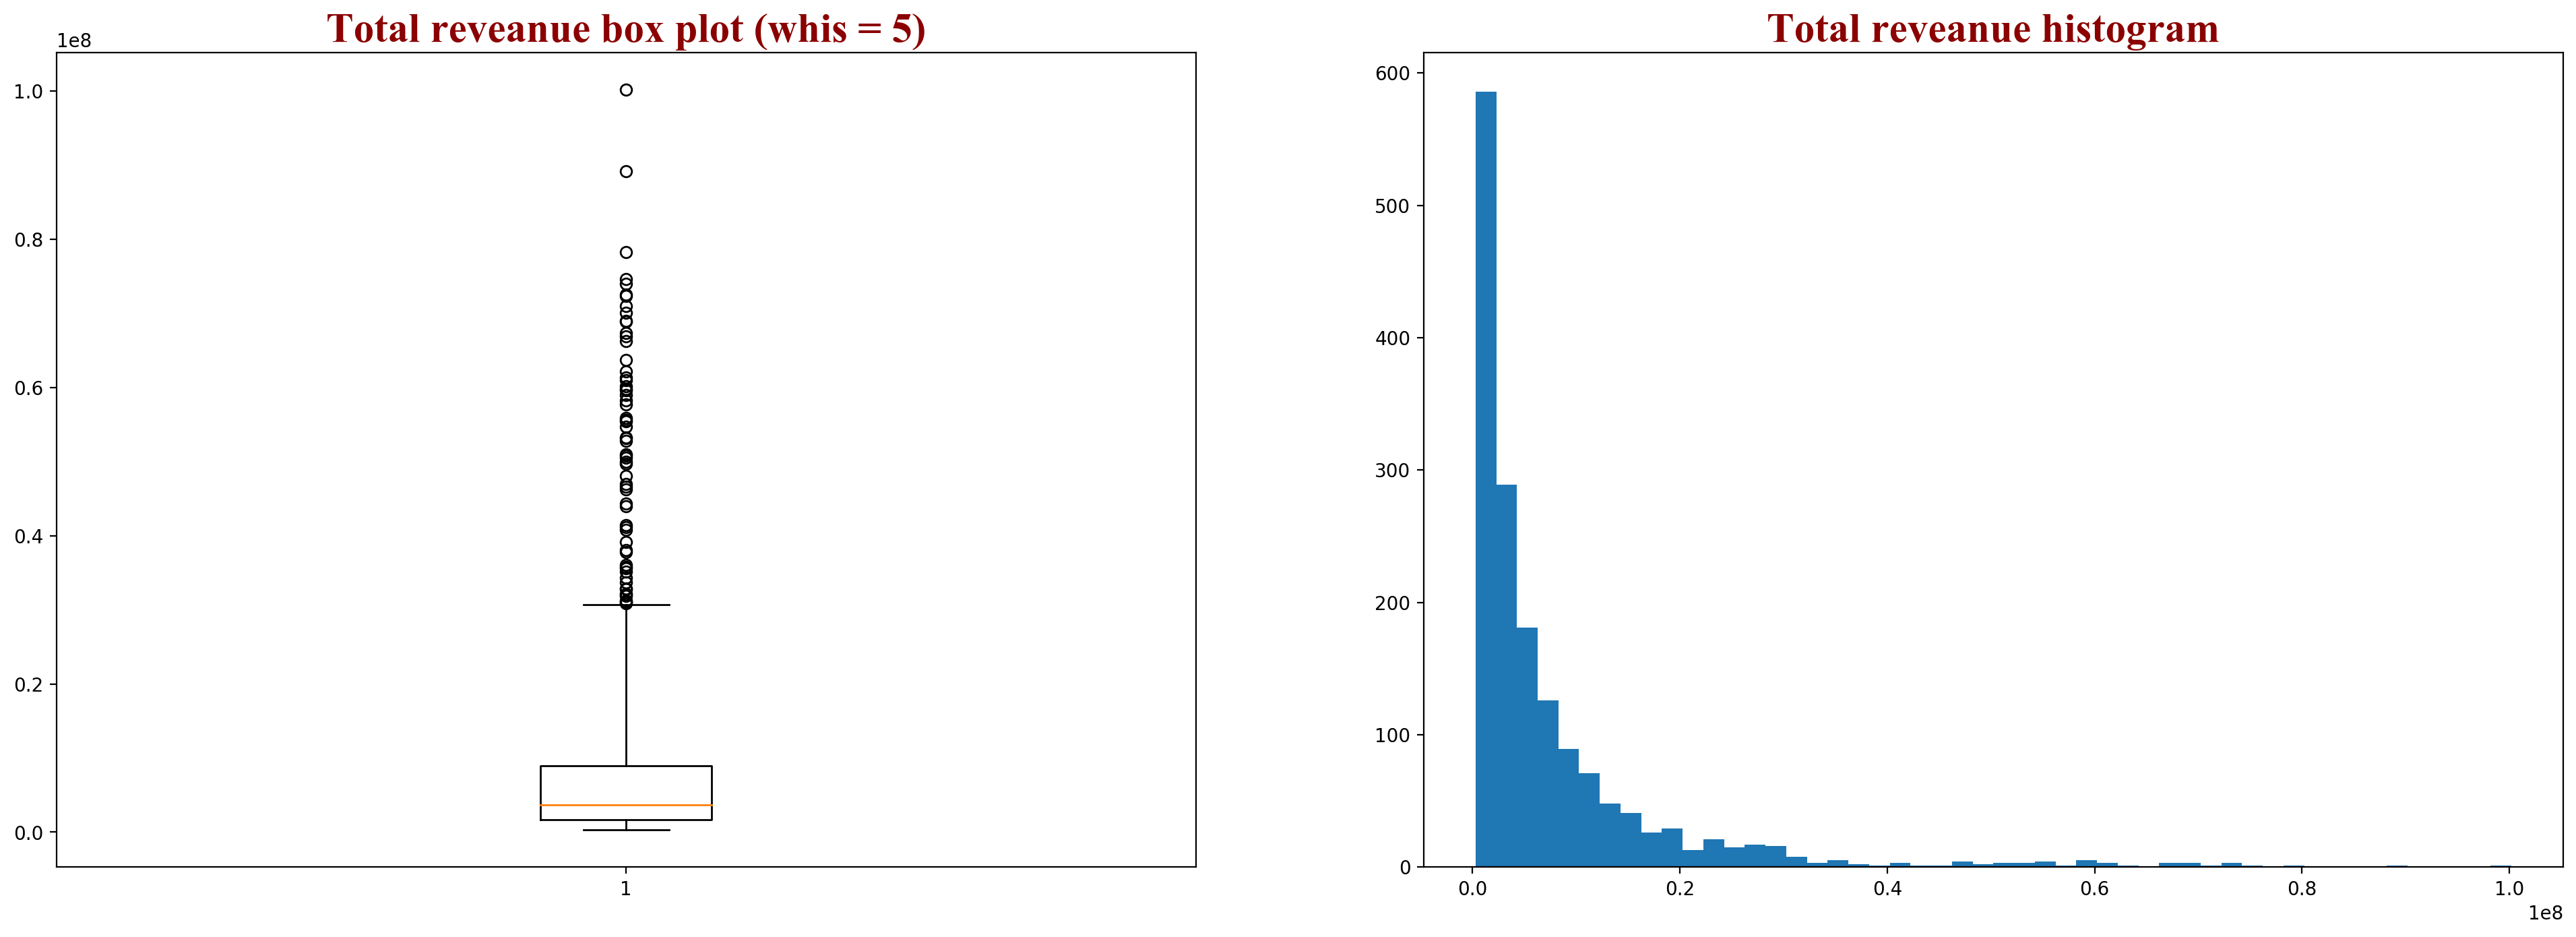

In [194]:
plt.figure(figsize=(24,8), dpi = 200)
plt.subplot(121)
plt.title('Total reveanue box plot', fontdict = title_font)
plt.boxplot(dm['TOTAL_REVENUE'], whis=3)

plt.subplot(122)
plt.title('Total reveanue histogram', fontdict = title_font)
plt.hist(dm['TOTAL_REVENUE'], bins = 50)
plt.show()


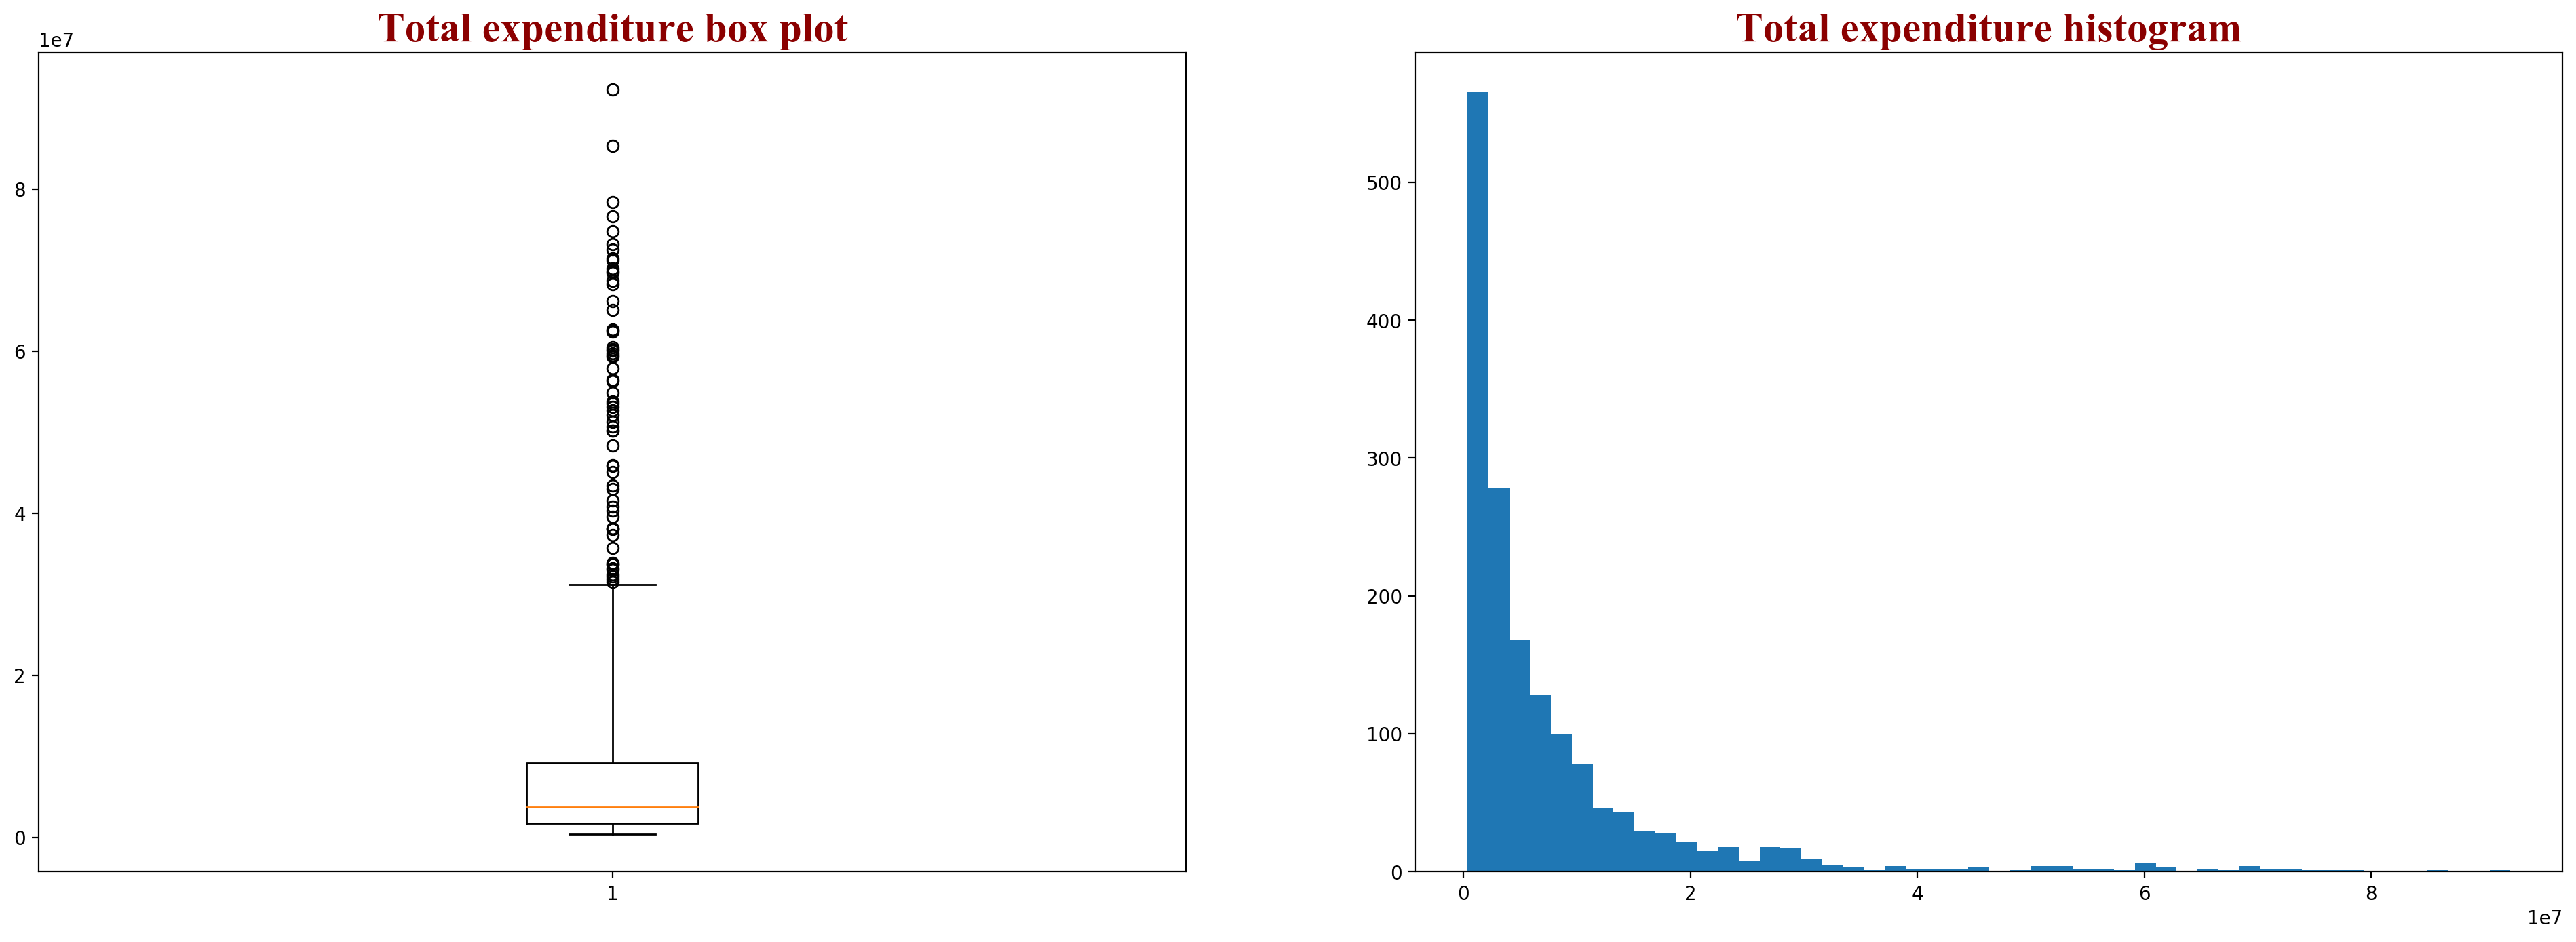

In [198]:
plt.figure(figsize=(24,8), dpi = 200)
plt.subplot(121)
plt.title('Total expenditure box plot', fontdict = title_font)
plt.boxplot(dm['TOTAL_EXPENDITURE'], whis=3)

plt.subplot(122)
plt.title('Total expenditure histogram', fontdict = title_font)
plt.hist(dm['TOTAL_EXPENDITURE'], bins = 50)
plt.show()

In [ ]:
q75, q25 = np.percentile(dm["TOTAL_REVENUE"], [75 ,25])
q75, q25

caa = q75 - q25


esik_degerleri = pd.DataFrame()

for esik_degeri in np.arange(1,5,0.5):
    min_deger = q25 - (caa*esik_degeri)
    maks_deger = q75 + (caa*esik_degeri)
    aykiri_deger_sayisi = len((np.where((dm["TOTAL_REVENUE"] > maks_deger)| 
                                       (dm["TOTAL_REVENUE"] < min_deger))[0]))
    esik_degerleri = esik_degerleri.append({'esik_degeri': esik_degeri,'aykiri_deger_sayısı': aykiri_deger_sayisi}, ignore_index=True)

esik_degerleri

### Q2
Toplam gelir (TOTAL_REVENUE) ve toplam harcama (TOTAL_EXPENDITURE) değişkenlerinde aykırı değer tespit ettiyseniz bu derste öğrendiğiniz teknikleri uygulayarak bu aykırı değerleri ortadan kaldırın ve bunu yaptıktan sonra hiçbir aykırı değer kalmadığını doğrulayın.

In [210]:
from scipy.stats.mstats import winsorize

winsorize_revenue = winsorize(dm["TOTAL_REVENUE"], (0, 0.10))
winsorize_expenditure = winsorize(dm["TOTAL_EXPENDITURE"], (0, 0.10))

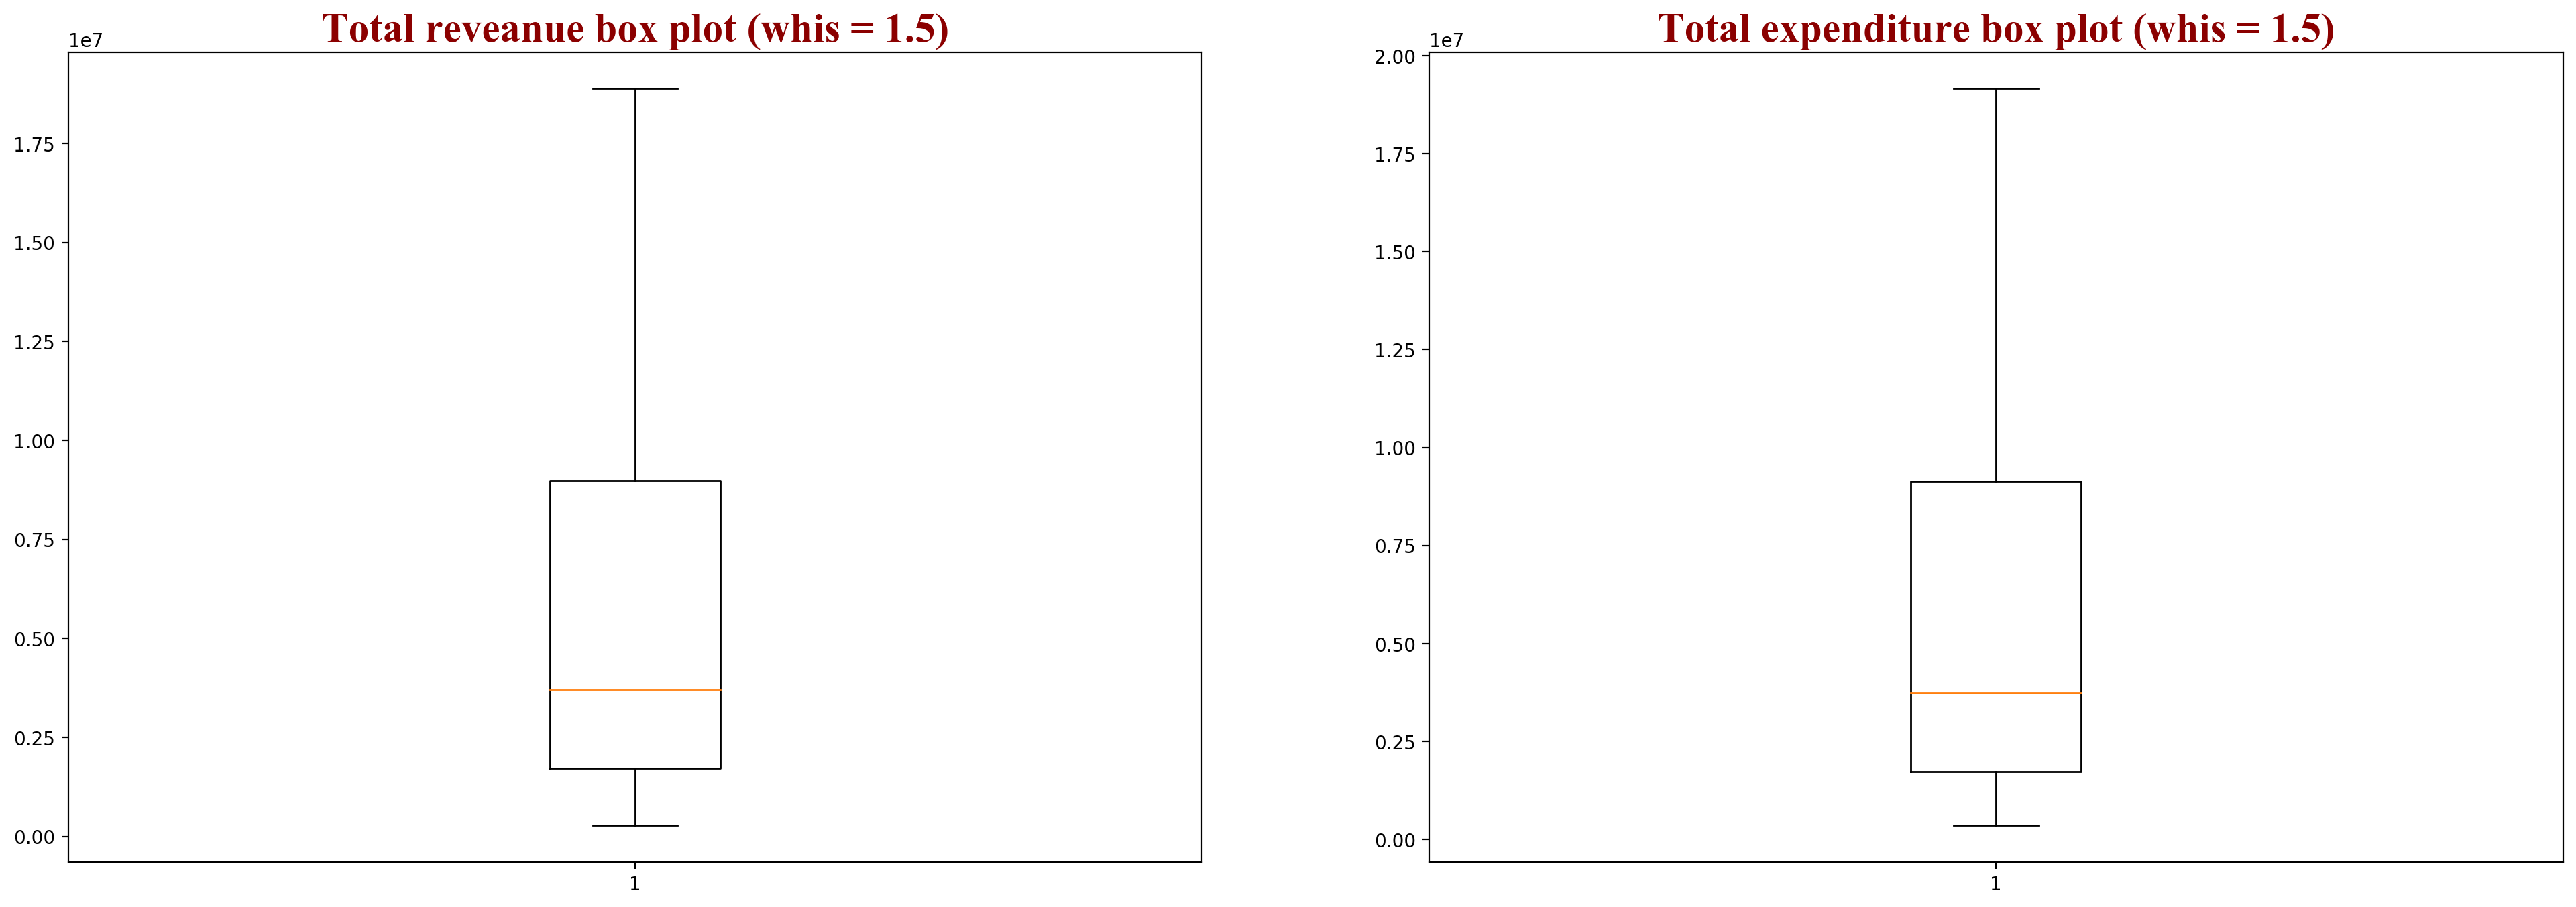

In [211]:
plt.figure(figsize=(24,8), dpi = 200)
plt.subplot(121)
plt.title('Total reveanue box plot (whis = 1.5)', fontdict = title_font)
plt.boxplot(winsorize_revenue, whis=1.5)
plt.subplot(122)
plt.title('Total expenditure box plot (whis = 1.5)', fontdict = title_font)
plt.boxplot(winsorize_expenditure, whis=1.5)
plt.show()

### Q3
Toplam gelir (TOTAL_REVENUE) değişkeninden, toplam harcama (TOTAL_EXPENDITURE) değerini çıkartarak bütçe açığı olarak düşünülebilecek bir değişken oluşturun (aykırı değerleri temizlemeden). Bu yeni değişkende de aykırı değerler yer almakta mı? Varsa bu aykırı değerleri de temizleyin.


In [213]:
dm['TOTAL_DEFICIT'] = dm['TOTAL_REVENUE'] - dm ['TOTAL_EXPENDITURE']
dm

,STATE,YEAR,TOTAL_REVENUE,TOTAL_EXPENDITURE,TOTAL_DEFICIT
PRIMARY_KEY,,,,,
1986_ALABAMA,ALABAMA,1986,1217233.0,1062563.0,154670.0
1986_ALASKA,ALASKA,1986,892987.0,722083.0,170904.0
1986_ARIZONA,ARIZONA,1986,1840862.0,2077062.0,-236200.0
1986_ARKANSAS,ARKANSAS,1986,856538.0,950017.0,-93479.0
1986_CALIFORNIA,CALIFORNIA,1986,13337032.0,16189998.0,-2852966.0
...,...,...,...,...,...
2017_VIRGINIA,VIRGINIA,2017,16661024.0,16881828.0,-220804.0
2017_WASHINGTON,WASHINGTON,2017,16219286.0,16876454.0,-657168.0
2017_WEST_VIRGINIA,WEST_VIRGINIA,2017,3304757.0,3266151.0,38606.0


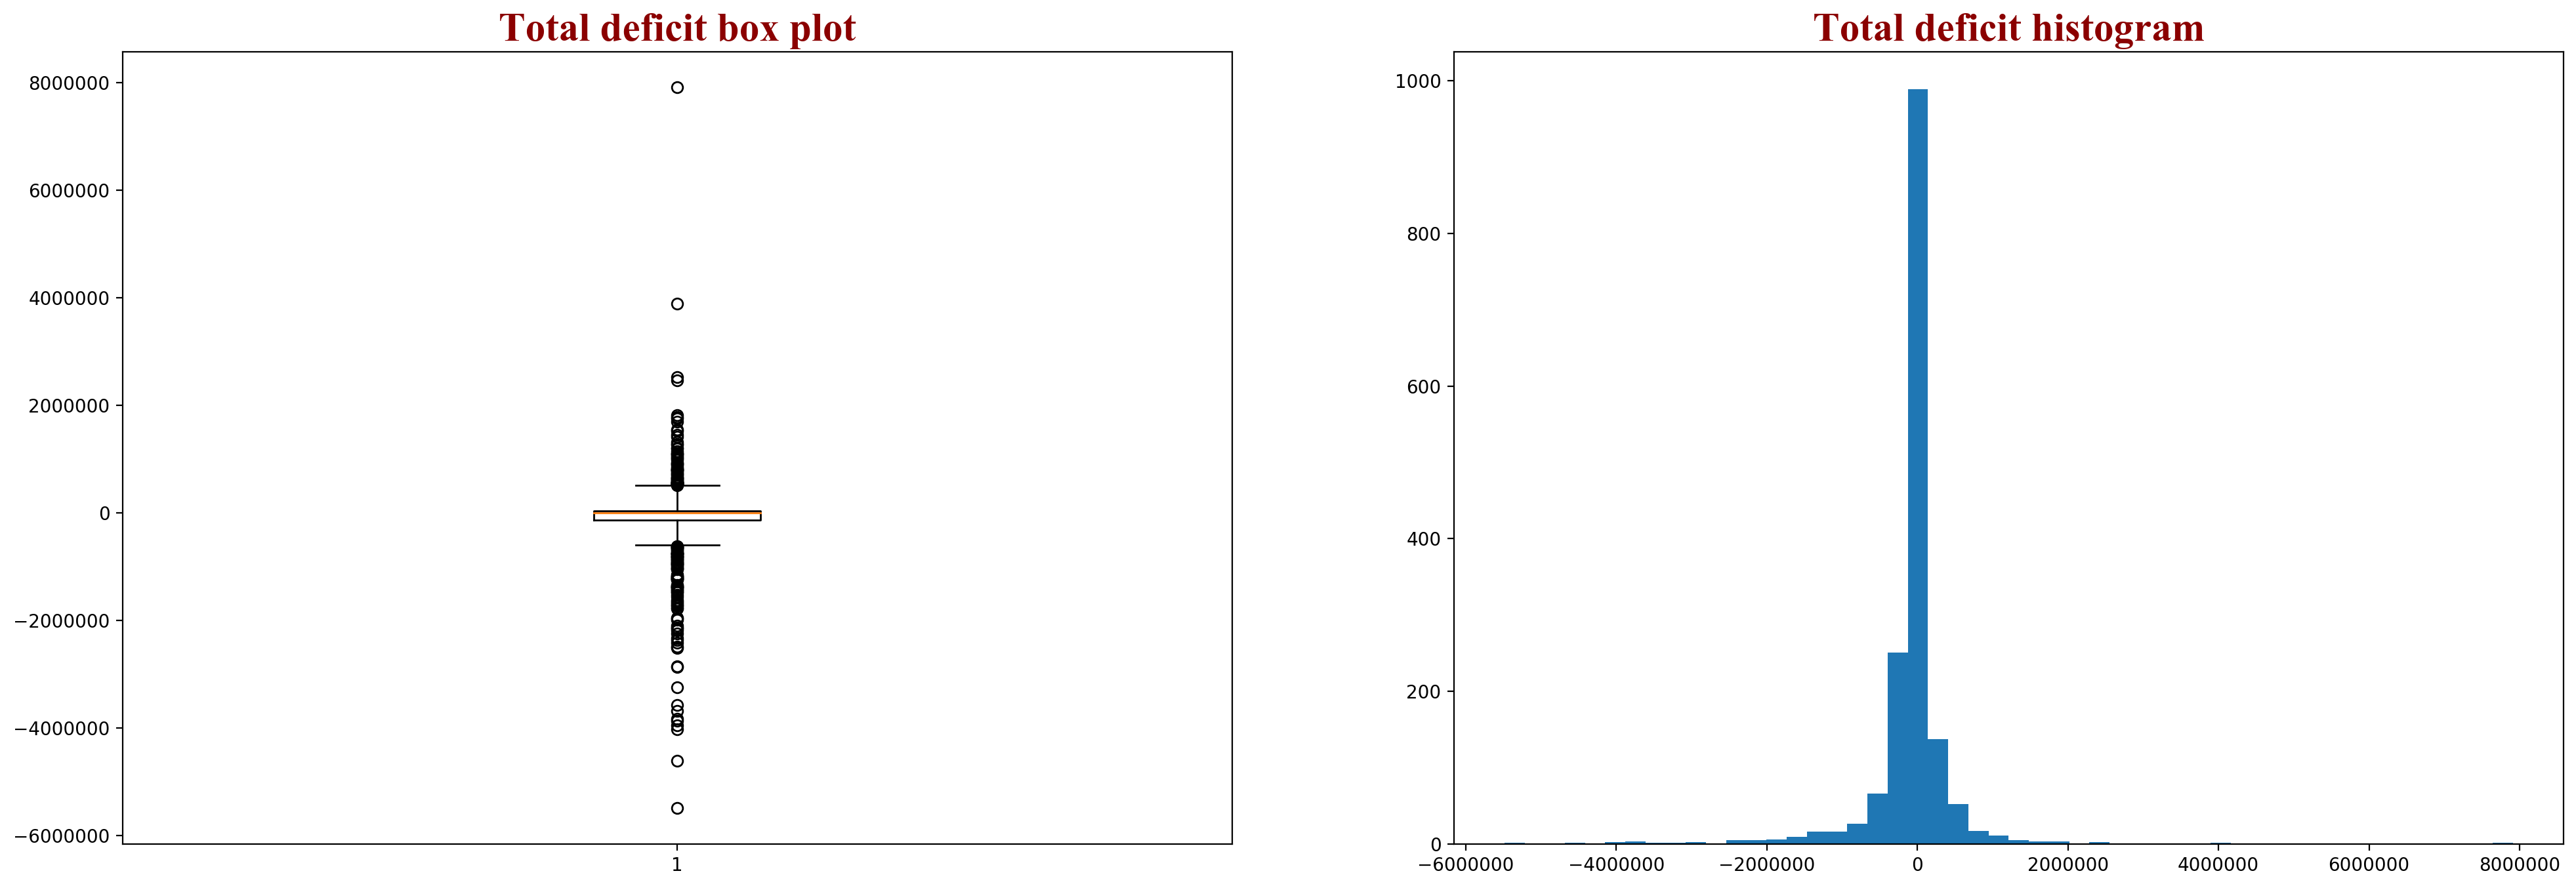

In [214]:
plt.figure(figsize=(24,8), dpi = 200)
plt.subplot(121)
plt.title('Total deficit box plot', fontdict = title_font)
plt.boxplot(dm['TOTAL_DEFICIT'], whis=3)

plt.subplot(122)
plt.title('Total deficit histogram', fontdict = title_font)
plt.hist(dm['TOTAL_DEFICIT'], bins = 50)
plt.show()

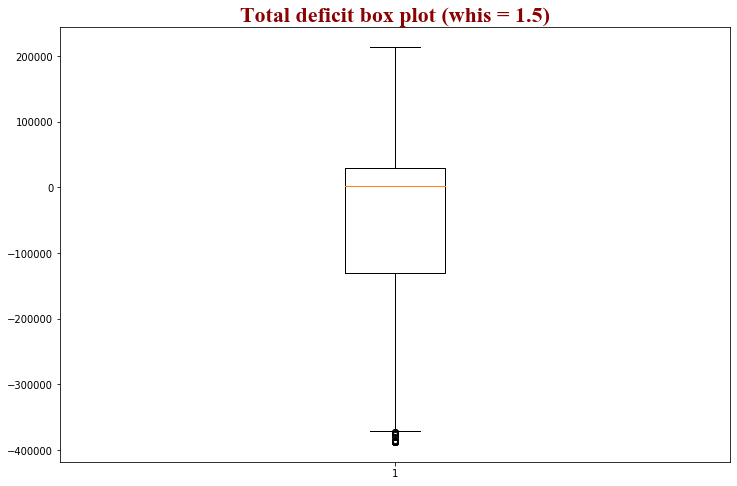

In [225]:
winsorize_deficit = winsorize(dm["TOTAL_DEFICIT"], (0.1,0.1))
plt.figure(figsize=(12,8))
plt.title('Total deficit box plot (whis = 1.5)', fontdict = title_font)
plt.boxplot(winsorize_deficit, whis=1.5)
plt.show()

### Q4
Yine toplam gelir (TOTAL_REVENUE) değişkeninden, toplam harcama(TOTAL_EXPENDITURE) değerini çıkartarak bütçe açığı olarak düşünülebilecek bir değişken oluşturun. Fakat bu sefer aykırı değerleri temezledikten sonra bu işlemi yapın. Bu yeni değişkende de aykırı değerler var mı? Varsa bunları da temizlemekte fayda var.

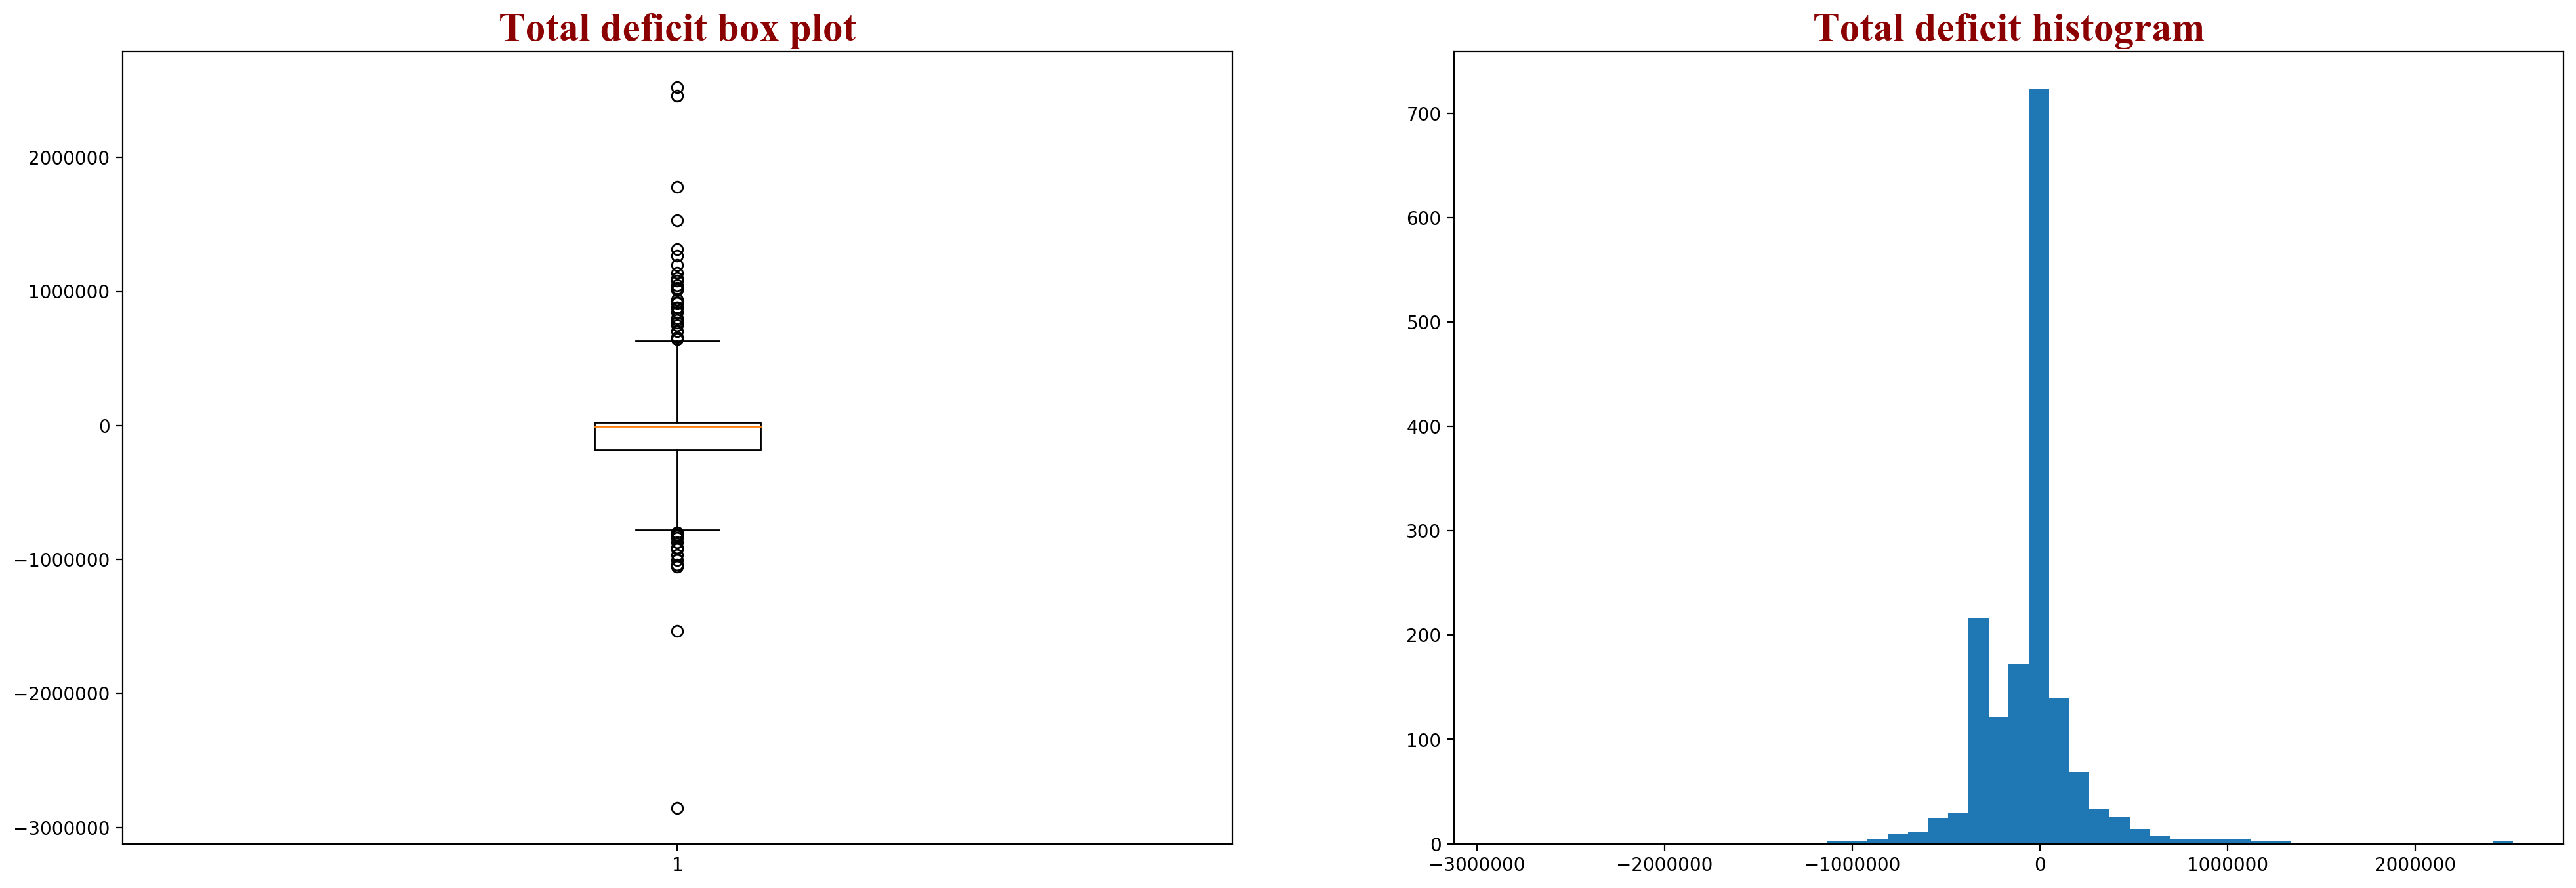

In [228]:
from scipy.stats.mstats import winsorize

winsorize_revenue = winsorize(dm["TOTAL_REVENUE"], (0, 0.10))
winsorize_expenditure = winsorize(dm["TOTAL_EXPENDITURE"], (0, 0.10))
dm["TOTAL_REVENUE"] = winsorize_revenue
dm["TOTAL_EXPENDTURE"] = winsorize_expenditure

dm['TOTAL_DEFICIT'] = dm['TOTAL_REVENUE'] - dm ['TOTAL_EXPENDITURE']

plt.figure(figsize=(24,8), dpi = 200)
plt.subplot(121)
plt.title('Total deficit box plot', fontdict = title_font)
plt.boxplot(dm['TOTAL_DEFICIT'], whis=3)

plt.subplot(122)
plt.title('Total deficit histogram', fontdict = title_font)
plt.hist(dm['TOTAL_DEFICIT'], bins = 50)
plt.show()

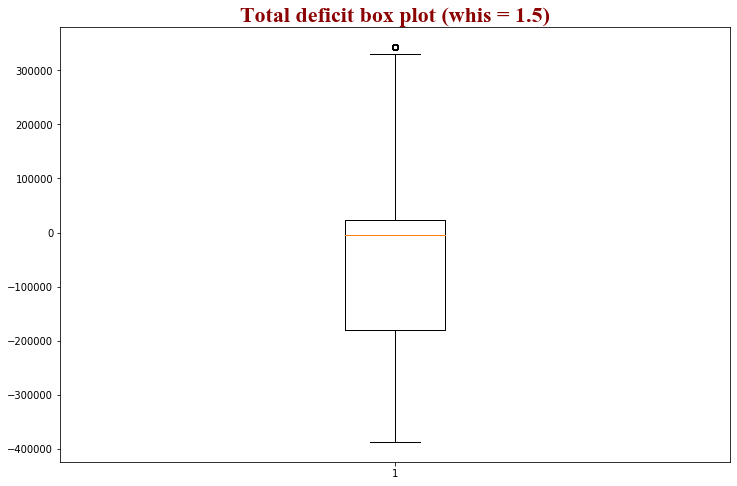

In [232]:
winsorize_deficit = winsorize(dm["TOTAL_DEFICIT"], (0.05,0.05))
plt.figure(figsize=(12,8))
plt.title('Total deficit box plot (whis = 1.5)', fontdict = title_font)
plt.boxplot(winsorize_deficit, whis=1.5)
plt.show()

### Q5
Şimdi elimizde üçüncü ve ve dördüncü sorularda oluşturduğumuz iki farklı bütçe değişkeni var. Bu ikisi arasında fark görüyor musunuz?

- Toplam gelir (TOTAL_REVENUE) ve toplam harcama(TOTAL_EXPENDITURE) degiskeninden aykiri degerler temizlenmeden olusturulan butce degiskeninde aykiri degerlerin daha fazla oldugu gorulmektedir.

### Q6
Bizim için bütçe açığı çok önemli bir değişken olsaydı aykırı değerleri temizlemek için hangi yöntem daha iyi olurdu. Üçüncü soruda uguladığınız yöntem mi yoksa dördüncü sorudaki yöntem mi?

- Yeni degiskeni olusturan degiskenlerin oncesinde aykiri degerlerden temizlenmesi daha mantikli olurdu. Cunku olusturulan yeni degiskendeki aykiri degerlerin de temizlenecegi dusunuldugunde degiskenler birbiri ile iliskili oldugundan aykiri deger temizligi sonrasi tutarsizliklar daha fazla gorulebilir.